In [2]:
!pip3 install torch torchvision
!pip3 install fastai

     |████████████████████████████████| 186 kB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 23.8 MB 49.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.9 MB 22.2 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 189 kB/s  eta 0:00:01
     |████████████████████████████████| 11.3 MB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 457 kB 33.7 MB/s eta 0:00:01
     |████████████████████████████████| 629 kB 31.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 26.9 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 27 kB/s s eta 0:00:01
     |████████████████████████████████| 58 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 82 kB 217 kB/s  eta 0:00:01
     |████████████████████████████████| 303 kB 30.4 MB/s eta 0:00:01
  Attempting uninstall: click
    Found existing installation: click 8.0.1
    Uninstalling click-8.0.1:
 

In [3]:
# helper functions for fast.ai

# def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
#     x = torch.linspace(min,max)
#     fig,ax = plt.subplots(figsize=figsize)
#     ax.plot(x,f(x))
#     if tx is not None: ax.set_xlabel(tx)
#     if ty is not None: ax.set_ylabel(ty)
#     if title is not None: ax.set_title(title)
        
        
def label_func(fname):
    '''
    function to grab folder name as label name
    '''
    return fname.parent.name

def get_dls(bs, size, augment=True):
    '''
    function to get datablocks
    '''
    if augment:
        batch_tfms=[*aug_transforms(size=size, 
                                    do_flip=True, 
                                    max_rotate = 10.0, 
                                    max_zoom=1.1, 
                                    min_scale=0.75), 
                    Normalize.from_stats(*imagenet_stats)]
    else:
        batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
        
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items=get_image_files, 
                       splitter=RandomSplitter(seed=42),
                       get_y=label_func,
                       item_tfms=Resize(460),
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(path, bs=128)


def new_resnet(pretrained):
    '''
    fix for cnn_learner module using non-standard pre-trained models
    '''
    return default_res50

def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def random_test_image(img_dir, categories):
    """Pick a random test image from specified dir"""
    c = np.random.choice(categories)
    root = img_dir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    print(img_path)
    return img_path

In [4]:
from fastai.vision.all import *

In [5]:
# setting path variables 
Path.BASE_PATH = Path('../../MelvinWevers#9512/DeBoer_Train')
Path.BASE_PATH.ls()
path = Path.BASE_PATH

In [6]:
data = get_dls(128, 224)
classes = data.vocab

/opt/conda/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [7]:
# th architecture to use
arch = 'resnet50'

# (down)load the pre-trained weights
model_weights = '%s_places365.pth.tar' % arch
if not os.access(model_weights, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_weights
    os.system('wget ' + weight_url)
    
places_res50 = torch.load(model_weights,  
                          map_location=lambda storage, 
                          loc: storage)

default_res50 = models.resnet50()
state_dict = places_res50['state_dict'] 
new_state_dict = OrderedDict()

for key in state_dict.keys():
    new_state_dict[key[7:]]= state_dict[key]
    

default_res50.fc = torch.nn.Linear(2048, 365) # Matching with default res50 dense layer
default_res50.load_state_dict(new_state_dict)

<All keys matched successfully>

In [8]:
learn = cnn_learner(get_dls(128, 224, augment=True), 
                    new_resnet,
                    #models.resnet34,
                    metrics=[top_k_accuracy, 
                             accuracy,
                             error_rate])

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    
                                                   fname='deboer_baseline'), 
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,error_rate,time
0,4.802175,3.029920,0.596447,0.327411,0.672589,00:36
1,3.625664,2.268492,0.749366,0.466371,0.533629,00:29
2,2.904247,1.879558,0.809010,0.539340,0.460660,00:28
3,2.363202,1.698921,0.835660,0.574239,0.425761,00:28
4,2.001698,1.627491,0.849619,0.590102,0.409898,00:28
5,1.767174,1.600981,0.851523,0.590736,0.409264,00:29
6,1.579166,1.532401,0.864213,0.608503,0.391497,00:28
7,1.430176,1.567667,0.855330,0.599619,0.400381,00:29
8,1.324923,1.524329,0.868655,0.609137,0.390863,00:28
9,1.236876,1.589263,0.859772,0.598350,0.401650,00:28


Better model found at epoch 0 with valid_loss value: 3.0299198627471924.
Better model found at epoch 1 with valid_loss value: 2.2684922218322754.
Better model found at epoch 2 with valid_loss value: 1.8795578479766846.
Better model found at epoch 3 with valid_loss value: 1.6989209651947021.
Better model found at epoch 4 with valid_loss value: 1.6274912357330322.
Better model found at epoch 5 with valid_loss value: 1.6009814739227295.
Better model found at epoch 6 with valid_loss value: 1.5324013233184814.
Better model found at epoch 8 with valid_loss value: 1.5243291854858398.
No improvement since epoch 6: early stopping


In [10]:
data = get_dls(128, 224)
classes = data.vocab

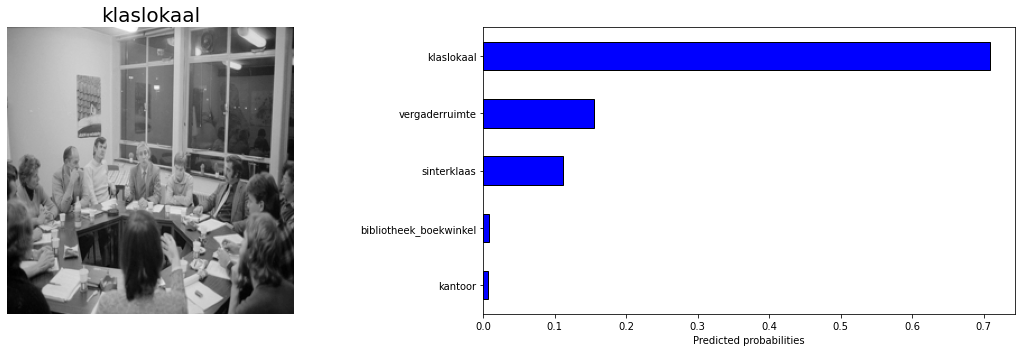

In [12]:
valid_paths = data.valid_ds.items
random_path = random.choice(valid_paths)
label, y, output = learn.predict(random_path)
img = Image.open(random_path)
img = img.resize((256, 256))
probs, preds = output.topk(5)
top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)


plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
ax.set_title(label, size=20)
ax = plt.imshow(img, cmap='gray')

plt.axis('off')
ax = plt.subplot(1, 2, 2)
result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
plt.xlabel('Predicted probabilities')
plt.tight_layout()
plt.savefig('dining_room.png', dpi=300, bbox_inches='tight')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

In [14]:
interp.most_confused(min_val=5)

[('uitreiking_huldiging', 'groepsportret', 8),
 ('boten', 'haven', 6),
 ('gebouw', 'woonwijk', 6),
 ('mensen_massa', 'optocht', 6),
 ('woonwijk', 'gebouw', 6),
 ('portret', 'woonkamer', 5),
 ('vergaderruimte', 'klaslokaal', 5)]

In [15]:
interp.print_classification_report()

                        precision    recall  f1-score   support

                 akker       0.44      0.50      0.47         8
           amfitheater       1.00      0.67      0.80         3
                  aula       0.33      0.62      0.43        13
                  auto       0.00      0.00      0.00         7
          auto_ongeluk       0.73      0.50      0.59        16
              bakkerij       0.00      0.00      0.00         2
     basketbal_korfbal       0.85      1.00      0.92        11
         begraafplaats       1.00      0.25      0.40         4
            begrafenis       0.25      0.29      0.27         7
bibliotheek_boekwinkel       0.43      0.75      0.55         4
        binnen_zwembad       0.70      0.70      0.70        10
               bloemen       0.14      0.50      0.22         2
           bloementuin       0.75      0.38      0.50         8
                boksen       0.50      0.50      0.50         2
     borden_gevelsteen       0.50      

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1

In [16]:
learn.save('DeBoer_places')

Path('models/DeBoer_places.pth')

In [45]:
learn = cnn_learner(get_dls(128, 224, augment=True), 
                    new_resnet,
                    #models.resnet34,
                    metrics=[top_k_accuracy, 
                             accuracy,
                             error_rate])

In [46]:
learn.load('DeBoer_places')

In [47]:
label, y, output = learn.predict('../../MelvinWevers#9512/DeBoer_Train/auto_ongeluk/NL-HlmNHA_1478_08130_G.jpg')

In [18]:
learn.export('./models/DeBoer_places.pkl')

In [48]:
probs, preds = output.topk(5)
top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)

In [49]:
result

,p
auto_ongeluk,0.851779
auto,0.053180
trein_ongeluk,0.019182
akker,0.019047
kamperen,0.018278


In [40]:
def make_prediction(path, topk=5):
    output_ = {}
    label, y, output = learner.predict(path)
    probs, preds = output.topk(125)
    for index, class_ in enumerate(preds):
        output_[classes[class_]] = round(float(probs[index]),4)
    return output_

In [35]:
learner = load_learner('./models/DeBoer_places.pkl')

In [44]:
make_prediction('../../MelvinWevers#9512/DeBoer_Train/bruiloft/NL-HlmNHA_1478_08555_G.jpg')

{'slagerij': 0.1767,
 'circus': 0.1187,
 'vlag_hijsen': 0.0552,
 'duinen': 0.0462,
 'zeepkistenrace': 0.0284,
 'markt': 0.0275,
 'theater': 0.0264,
 'motorfiets': 0.0256,
 'tafel_tennis': 0.0204,
 'dieren_overig': 0.0202,
 'rugby': 0.0171,
 'handbal': 0.0171,
 'schaken_dammen': 0.0171,
 'zwaan': 0.0166,
 'herdenking': 0.0148,
 'windmolen': 0.014,
 'bos_park': 0.0139,
 'water_ski': 0.0136,
 'hockey': 0.0134,
 'geestelijken': 0.0132,
 'tennis': 0.0117,
 'zaalvoetbal': 0.0115,
 'koe': 0.0102,
 'fabriek': 0.0097,
 'uitreiking_huldiging': 0.0092,
 'trein_ongeluk': 0.0091,
 'sneeuwlandschap': 0.0084,
 'vergaderruimte': 0.0082,
 'wielrennen': 0.008,
 'buiten_zwembad': 0.0077,
 'cafe': 0.0075,
 'dansende_mensen': 0.0074,
 'demonstratie': 0.0073,
 'cricket': 0.0067,
 'begraafplaats': 0.0059,
 'konijn': 0.0053,
 'terras': 0.0053,
 'trein': 0.0051,
 'straat': 0.005,
 'begrafenis': 0.0049,
 'bloementuin': 0.0045,
 'sinterklaas': 0.0045,
 'groepsportret': 0.0044,
 'tram': 0.0044,
 'luchtfoto': 0.00